In [4]:
import os
from os.path import join
import re
import collections
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Seq import Seq

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Effect of interventions

To compare the effect of interventions vs original results we can compute the rank difference of all domains in each output. 

In [134]:
def load_assembly_bias_results(query_type, tail='left', intervention=None):
    if intervention is None:
        path = join(cwd, f'data/{query_type}_probability_{tail}.csv')
    else:
        path = join(cwd, f'data/intervention/{intervention}/{query_type}_probability_{tail}.csv')
        
    df = pd.read_csv(path, index_col='id' if query_type == 'tigr' else 'query')
    df['rank'] = list(range(1, len(df) + 1))
    return df

In [135]:
pfam_original = load_assembly_bias_results('pfam')
tigr_original = load_assembly_bias_results('tigr')

pfam_swap = load_assembly_bias_results('pfam', intervention='swap')
tigr_swap = load_assembly_bias_results('tigr', intervention='swap')

pfam_shuffle = load_assembly_bias_results('pfam', intervention='shuffle')
tigr_shuffle = load_assembly_bias_results('tigr', intervention='shuffle')

In [136]:
pfam_swap.head()

,id,description,log_probability,log_probability_random,n_elements,evidence,evidence_strength,rank
query,,,,,,,,
AAA,PF00004,ATPase family associated with various cellular...,-2.823057,-3.345152,53,0.226743,Weak,1
Helicase_C,PF00271,Helicase conserved C-terminal domain,-2.343728,-2.855657,53,0.222328,Weak,2
AAA_5,PF07728,AAA domain (dynein-related subfamily),-2.354430,-2.781236,53,0.185359,Weak,3
ABC_tran,PF00005,ABC transporter,-3.106263,-3.532605,53,0.185158,Weak,4
ResIII,PF04851,Type III restriction enzyme; res subunit,-1.879120,-2.288695,53,0.177876,Weak,5


### Compute difference between original and intervention

In [139]:
def compute_difference_with_original_in_place(original_df, intervention_df):
    indices = set(original_df.index.tolist()) & set(intervention_df.index.tolist())
    original_df_copy = original_df.loc[indices].sort_values('rank').copy()
    original_df_copy['rank'] = range(1, len(indices) + 1)
    for ix in indices:
        original_rank = original_df_copy.loc[ix]['rank']
        intervention_rank = intervention_df.loc[ix]['rank']
        intervention_df.loc[ix, 'rank_original'] = original_rank
        intervention_df.loc[ix, 'rank_intervention'] = intervention_rank
        intervention_df.loc[ix, 'rank_diff'] = original_rank - intervention_rank
        intervention_df.loc[ix, 'rank_diff_abs'] = np.abs(original_rank - intervention_rank)

In [140]:
compute_difference_with_original_in_place(pfam_original, pfam_swap)
compute_difference_with_original_in_place(pfam_original, pfam_shuffle)
compute_difference_with_original_in_place(tigr_original, tigr_swap)
compute_difference_with_original_in_place(tigr_original, tigr_shuffle)

In [141]:
trna_synt_tigr_id = tigr_swap[
    tigr_swap['description'].notnull() & 
    tigr_swap['description'].str.contains('--tRNA ligase')
].index
len(trna_synt_tigr_id)

34

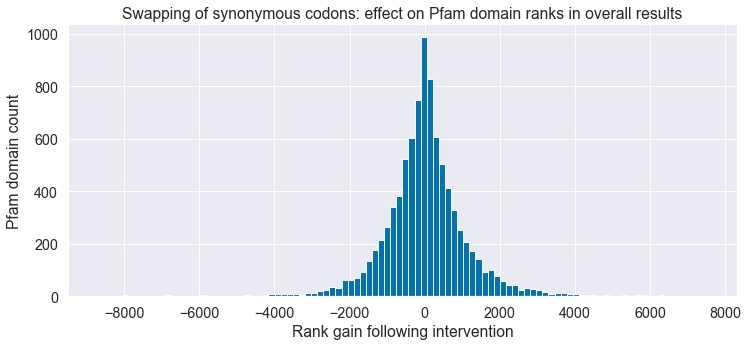

In [142]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(pfam_swap[pfam_swap['rank_diff'].notnull()]['rank_diff'].values, bins=100);
ax.set_title('Swapping of synonymous codons: effect on Pfam domain ranks in overall results');
ax.set_xlabel('Rank gain following intervention');
ax.set_ylabel('Pfam domain count');

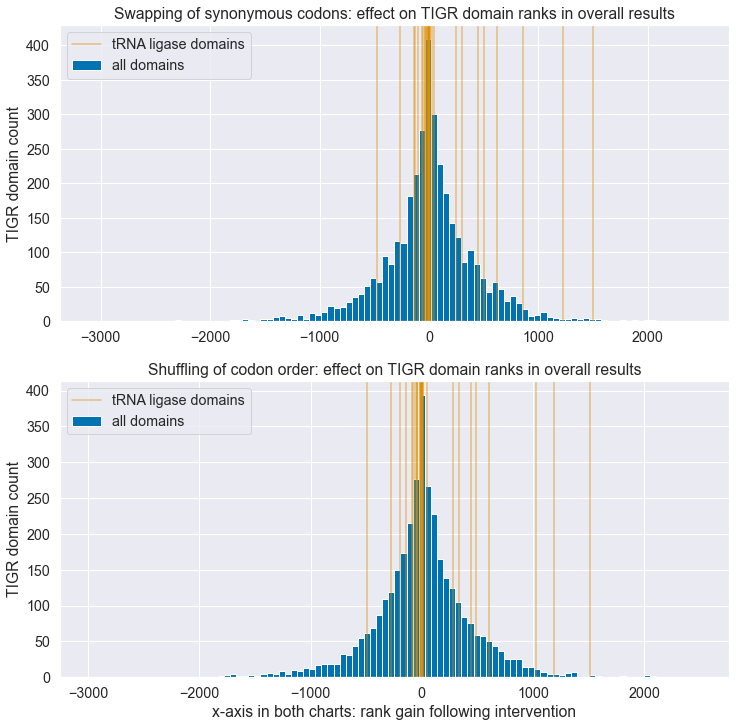

In [169]:
_, axes = plt.subplots(2, 1, figsize=(12, 12))
ax = axes[0]
ax.hist(tigr_swap[tigr_swap['rank_diff'].notnull()]['rank_diff'].values, bins=100, label='all domains');
for i, tigr_id in enumerate(trna_synt_tigr_id):
    label = 'tRNA ligase domains' if i == 0 else None
    ax.axvline(tigr_swap.loc[tigr_id]['rank_diff'], color=palette[1], alpha=0.5, label=label)
ax.set_title('Swapping of synonymous codons: effect on TIGR domain ranks in overall results');
ax.set_xlabel('');
ax.set_ylabel('TIGR domain count');
ax.legend();

ax2 = axes[1]
ax2.hist(tigr_shuffle[tigr_shuffle['rank_diff'].notnull()]['rank_diff'].values, bins=100, label='all domains');
for i, tigr_id in enumerate(trna_synt_tigr_id):
    label = 'tRNA ligase domains' if i == 0 else None
    ax2.axvline(tigr_shuffle.loc[tigr_id]['rank_diff'], color=palette[1], alpha=0.5, label=label)
ax2.set_title('Shuffling of codon order: effect on TIGR domain ranks in overall results');
ax2.set_xlabel('x-axis in both charts: rank gain following intervention');
ax2.set_ylabel('TIGR domain count');
ax2.legend();

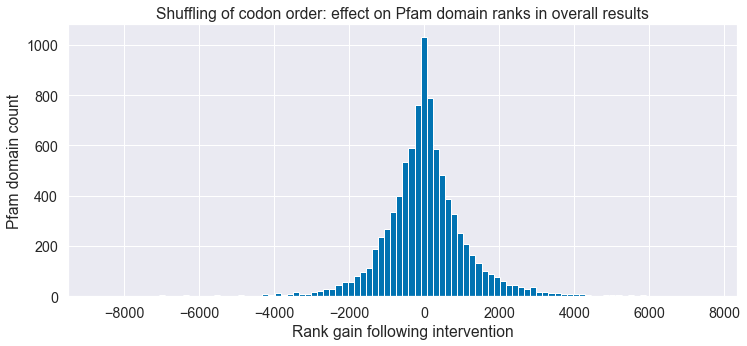

In [144]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(pfam_shuffle[pfam_shuffle['rank_diff'].notnull()]['rank_diff'].values, bins=100);
ax.set_title('Shuffling of codon order: effect on Pfam domain ranks in overall results');
ax.set_xlabel('Rank gain following intervention');
ax.set_ylabel('Pfam domain count');

In [157]:
swap_out_df = tigr_swap.loc[trna_synt_tigr_id].sort_values('rank_diff_abs', ascending=True)[
    ['query', 'description', 'rank_original', 'rank_intervention', 'rank_diff']
].copy()
swap_out_df['rank_original'] = swap_out_df['rank_original'].astype(int)
swap_out_df['rank_intervention'] = swap_out_df['rank_intervention'].astype(int)
swap_out_df['rank_diff'] = swap_out_df['rank_diff'].astype(int)
swap_out_df.to_csv('/Users/srom/Downloads/tigr_swap.csv');
swap_out_df

,query,description,rank_original,rank_intervention,rank_diff
id,,,,,
TIGR00398,metG,methionine--tRNA ligase,4,3,1
TIGR00392,ileS,isoleucine--tRNA ligase,3,5,-2
TIGR00422,valS,valine--tRNA ligase,5,7,-2
TIGR00456,argS,arginine--tRNA ligase,10,8,2
TIGR00468,pheS,phenylalanine--tRNA ligase; alpha subunit,24,27,-3
TIGR00459,aspS_bact,aspartate--tRNA ligase,36,33,3
TIGR00418,thrS,threonine--tRNA ligase,11,15,-4
TIGR00233,trpS,tryptophan--tRNA ligase,20,24,-4
TIGR00344,alaS,alanine--tRNA ligase,7,12,-5


In [158]:
shuffle_out_df = tigr_shuffle.loc[trna_synt_tigr_id].sort_values('rank_diff_abs', ascending=True)[
    ['query', 'description', 'rank_original', 'rank_intervention', 'rank_diff']
].copy()
shuffle_out_df['rank_original'] = shuffle_out_df['rank_original'].astype(int)
shuffle_out_df['rank_intervention'] = shuffle_out_df['rank_intervention'].astype(int)
shuffle_out_df['rank_diff'] = shuffle_out_df['rank_diff'].astype(int)
shuffle_out_df.to_csv('/Users/srom/Downloads/tigr_shuffle.csv');
shuffle_out_df

,query,description,rank_original,rank_intervention,rank_diff
id,,,,,
TIGR00398,metG,methionine--tRNA ligase,4,3,1
TIGR00392,ileS,isoleucine--tRNA ligase,3,4,-1
TIGR00456,argS,arginine--tRNA ligase,10,8,2
TIGR00459,aspS_bact,aspartate--tRNA ligase,36,33,3
TIGR00422,valS,valine--tRNA ligase,5,9,-4
TIGR00418,thrS,threonine--tRNA ligase,11,15,-4
TIGR00468,pheS,phenylalanine--tRNA ligase; alpha subunit,24,28,-4
TIGR00344,alaS,alanine--tRNA ligase,7,12,-5
TIGR00435,cysS,cysteine--tRNA ligase,13,18,-5
